In [1]:
# Import the packages we'll need
from __future__ import print_function

%matplotlib inline
from matplotlib.pyplot import *
import string
from collections import OrderedDict
import numpy as np
from pyobjcryst import loadCrystal
from diffpy.srfit.pdf import DebyePDFGenerator, PDFGenerator, PDFParser
from diffpy.srfit.fitbase import Profile
from diffpy.srfit.fitbase import FitContribution, FitRecipe
from diffpy.srfit.fitbase import FitResults, initializeRecipe
from diffpy.Structure import Structure
from diffpy.Structure import loadStructure
import time
from scipy.optimize.minpack import leastsq
#from ase.io import write
#from ase.io import read
import copy
from diffpy.Structure import Atom

In [2]:
# Define functions for optimization and plotting that we will use later

def scipyOptimize(recipe):
    from scipy.optimize.minpack import leastsq
    print("Fit using scipy's LM optimizer")
    leastsq(recipe.residual, recipe.getValues())
    return

def plotRecipe(recipe, ax=None):
    """Plot recipe in the specified axes `ax`.

    If `ax` is None, create a new figure.

    Return `ax`
    """
    if ax is None:
        fig, ax = subplots()
    r = recipe.pdf.profile.x
    g = recipe.pdf.profile.y
    gcalc = recipe.pdf.evaluate()
    diffzero = -0.8 * max(g) * np.ones_like(g)
    diff = g - gcalc + diffzero
    ax.plot(r,g,'o',label="G(r) Data", mfc='none', mec='blue')
    ax.plot(r, gcalc,'r-',label="G(r) Fit")
    ax.plot(r,diff,'g-',label="G(r) diff")
    ax.plot(r, diffzero,'k-')
    ax.set_xlabel("$r (\AA)$")
    ax.set_ylabel("$G (\AA^{-2})$")
    ax.legend(loc=1)
    return ax

In [3]:
# Import the data and make it a PDFprofile. Define the range of the data that will be 
# used in the fit.

grdata =  'MoO2_t-BuOH_200-00050.gr'
pdfprofile = Profile()
pdfparser = PDFParser()
pdfparser.parseFile(grdata)
pdfprofile.loadParsedData(pdfparser)

# Setup the PDFgenerator 1 that calculates the PDF from the CIF-file

pdfgenerator_cluster1 = PDFGenerator("G1")
pdfgenerator_cluster1.setQmax(17.0)
pdfgenerator_cluster1.setQmin(0.5)
pdfgenerator_cluster1._calc.evaluatortype = 'OPTIMIZED'
pdfgenerator_cluster1.parallel(2)
# Load structure from the XYZ file.

xyzfile1 = "disrut_cluster_4x5x1.xyz"
xyz_structure1 = loadStructure(xyzfile1)
pdfgenerator_cluster1.setStructure(xyz_structure1, periodic = False)


# Add the profile and generator to the PDFcontribution
pdfcontribution = FitContribution("pdf")
pdfcontribution.setProfile(pdfprofile, xname="r") 
pdfcontribution.addProfileGenerator(pdfgenerator_cluster1)

In [4]:
# Define the wave function that arises from solvent-particle interaction in the sample

def npwave(r, wA, wlam, wphi, wr0, wsig, wasym):
    """Dampened sine-wave from equation (M-2) in Zoebel science supplement.
    """
    ysin = np.sin(2 * np.pi * (r/wlam - wphi))
    sigeff = np.zeros_like(r, dtype=float)
    lo = (r < wr0); hi = ~lo;
    sigeff[lo] = wsig / wasym
    sigeff[hi] = wsig * wasym
    yexp = np.exp(-1 * ((r - wr0) / (2 * sigeff))**2)
    rv = wA * ysin * yexp
    return rv

# Register the npwave function for the dispersed sample background.
pdfcontribution.registerFunction(npwave, name='npwave')

# Setup initial values for the wave-related parameters.
pdfcontribution.wA << 0
pdfcontribution.wlam << 5
pdfcontribution.wphi << 0
pdfcontribution.wr0 << 4
pdfcontribution.wsig << 2
pdfcontribution.wasym << 1;

In [5]:
#original parameters:
#    # Setup initial values for the wave-related parameters.
#pdfcontribution.wA << 0
#pdfcontribution.wlam << 5
#pdfcontribution.wphi << 0
#pdfcontribution.wr0 << 4
#pdfcontribution.wsig << 2
#pdfcontribution.wasym << 1;

Adjust partial PDF scaling so that refined scaling factors
are proportional to molar content of each phase.

In [6]:
# Modify the pdfcontribution equation to account for the npwave
# Use scaling factors proportional to molar content
pdfcontribution.setEquation('mc1*G1 + npwave')

In [7]:
# Define the recipe to do the fit and add it to the PDFcontribution

recipe = FitRecipe()
recipe.addContribution(pdfcontribution)

# Avoid too much output during fitting 
recipe.clearFitHooks()

# Add the scale factor.
recipe.addVar(pdfcontribution.mc1, 1.0, tag = "scale")

recipe.restrain('mc1', lb=0, ub = 3, sig=0.0001)

# set qdamp, qbroad for the instrument
qdamp = 0.034
#qbroad = 0.01

# Add the instrumental parameters s
pdfgenerator_cluster1.qdamp.value = qdamp
#pdfgenerator_cluster1.qbroad.value = qbroad

# Add the delta2 parameters for the two phases, and make sure they cannot take unphysical values
recipe.addVar(pdfgenerator_cluster1.delta2, 0, name = "delta2_cluster1", tag = "delta2")
recipe.restrain("delta2_cluster1", lb=0, ub = 7, sig=0.001) 

In [8]:
# Add variables related to the wave background:
recipe.addVar(pdfcontribution.wA, fixed=True, tag='wave')
recipe.addVar(pdfcontribution.wlam, fixed=True, tag='wave')
recipe.addVar(pdfcontribution.wphi, fixed=True, tag='wave')
recipe.addVar(pdfcontribution.wr0, fixed=True, tag='wave')
recipe.addVar(pdfcontribution.wsig, fixed=True, tag='wave')
recipe.addVar(pdfcontribution.wasym, fixed=True, tag='wave');

In [9]:
# Add ADP and "cell" for the cluster
phase_cluster1 = pdfgenerator_cluster1.phase
atoms1 = phase_cluster1.getScatterers()

lat1 = phase_cluster1.getLattice()

recipe.newVar("zoomscale1", 1.0, tag = "lat1")
recipe.newVar("zoomscale2", 1.0, tag = "lat1")
recipe.newVar("zoomscale3", 1.0, tag = "lat1")
recipe.constrain(lat1.a, 'zoomscale1')
recipe.constrain(lat1.b, 'zoomscale2')
recipe.constrain(lat1.c, 'zoomscale3')
recipe.restrain("zoomscale1", lb=0.97, ub = 1.03, sig=0.001)
recipe.restrain("zoomscale2", lb=0.97, ub = 1.03, sig=0.001)
recipe.restrain("zoomscale3", lb=0.97, ub = 1.03, sig=0.001)

Mo_cluster1 = recipe.newVar("Mo_Biso_cluster1", 0.4, tag = 'adp_mo')
O_cluster1 = recipe.newVar("O_Biso_cluster1", 0.4, tag = 'adp_o')
#Cl_cluster1 = recipe.newVar("Cl_Biso_cluster1", 0.4, tag = 'adp_cl')

for atom in atoms1:
    if atom.element.title() == "Mo":
        recipe.constrain(atom.Biso, Mo_cluster1)
    elif atom.element.title() == "O":
        recipe.constrain(atom.Biso, O_cluster1)
   # elif atom.element.title() == "Cl":
    #    recipe.constrain(atom.Biso, Cl_cluster1)
        
recipe.restrain("Mo_Biso_cluster1", lb=0.08, ub = 3, sig=0.001)

pos_limit1 = 0.22

for atom in atoms1:
    if atom.element == 'Mo':
        recipe.addVar(atom.x, name=atom.name+'_x1', tag='xyz1')
        recipe.addVar(atom.y, name=atom.name+'_y1', tag='xyz1')
        recipe.addVar(atom.z, name=atom.name+'_z1', tag='xyz1')       
        #restrain atomic positions
        lbx = atom.x.value-pos_limit1
        ubx = atom.x.value+pos_limit1
        recipe.restrain(atom.x, lb=lbx, ub = ubx, sig=0.001)
        lby = atom.y.value-pos_limit1
        uby = atom.y.value+pos_limit1
        recipe.restrain(atom.y, lb=lby, ub = uby, sig=0.001)
        lbz = atom.z.value-pos_limit1
        ubz = atom.z.value+pos_limit1
        recipe.restrain(atom.y, lb=lby, ub = uby, sig=0.001)

In [10]:
pdfprofile.setCalculationRange(xmin = 1.55, xmax = 10)

In [11]:
import matplotlib.pyplot as plt

Fit using scipy's LM optimizer


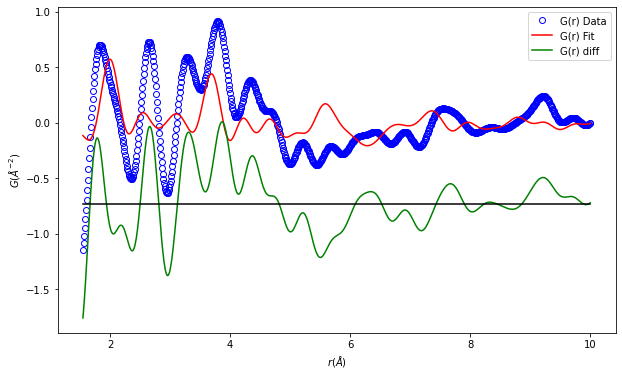

In [12]:
# Done with setting up, start the actual refinements!
fig, ax = plt.subplots(figsize=(10,6))
recipe.fix('all')
recipe.free('mc1')
scipyOptimize(recipe)
plotRecipe(recipe, ax=ax)
plt.show()
# print(FitResults(recipe))

Fit using scipy's LM optimizer


<AxesSubplot:xlabel='$r (\\AA)$', ylabel='$G (\\AA^{-2})$'>

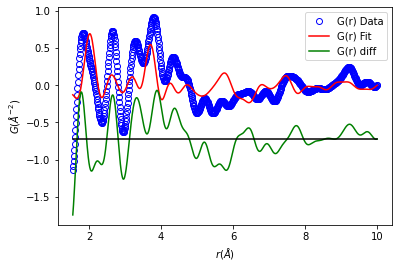

In [13]:
recipe.free('lat1')
scipyOptimize(recipe)
plotRecipe(recipe)
# print(FitResults(recipe))

Fit using scipy's LM optimizer


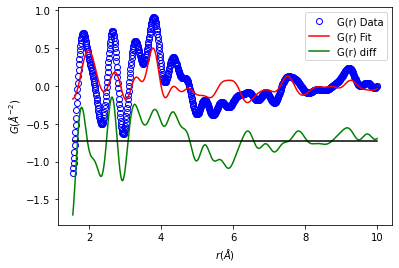

In [14]:
recipe.fix ('lat1')
recipe.free('xyz1')
scipyOptimize(recipe)
FitResults(recipe)
# print(FitResults(recipe))
plotRecipe(recipe);

Fit using scipy's LM optimizer


<AxesSubplot:xlabel='$r (\\AA)$', ylabel='$G (\\AA^{-2})$'>

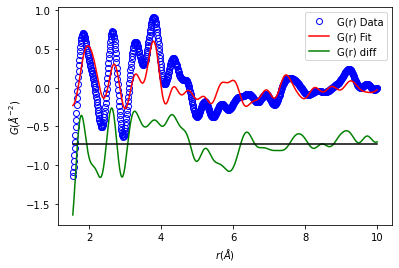

In [15]:
recipe.free('adp_mo')
scipyOptimize(recipe)
plotRecipe(recipe)
# print(FitResults(recipe))

Fit using scipy's LM optimizer
Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       33.03006737
Contributions  33.01839561
Restraints     0.01167176
Chi2           33.01839561
Reduced Chi2   0.03889093
Rw             0.63236804

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
Mo0_x1            1.93795762e+00 +/- 1.12513271e+06
Mo0_y1            2.57501257e+00 +/- 1.68112180e+06
Mo0_z1            5.93995562e+00 +/- 4.72278224e+05
Mo10_x1           -8.47076903e-01 +/- 4.16395423e+05
Mo10_y1           -1.65970269e-01 +/- 5.88561437e+05
Mo10_z1           5.79901278e+00 +/- 1.23292574e+05
Mo11_x1           1.84019450e+00 +/- 1.37814176e+06
Mo11_y1           4.72655934e+00 +/- 1.60803356e+06
Mo11_z1           9.41905592e-01 +/- 6.54101644e+05
Mo12_x1           2.03125427e+00 +/- 1.21403195e

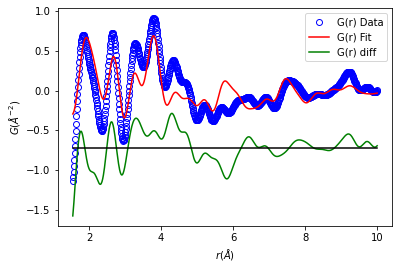

In [16]:
recipe.free('adp_o')
scipyOptimize(recipe)
plotRecipe(recipe)
print(FitResults(recipe))

In [17]:
#recipe.free('wave')
#scipyOptimize(recipe)
#plotRecipe(recipe)
# print(FitResults(recipe))

In [18]:
print(FitResults(recipe))

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       33.03006755
Contributions  33.01839578
Restraints     0.01167176
Chi2           33.01839578
Reduced Chi2   0.03889093
Rw             0.63236804

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
Mo0_x1            1.93795762e+00 +/- 1.13719108e+06
Mo0_y1            2.57501257e+00 +/- 1.69716302e+06
Mo0_z1            5.93995562e+00 +/- 4.75729377e+05
Mo10_x1           -8.47076903e-01 +/- 4.24398387e+05
Mo10_y1           -1.65970269e-01 +/- 5.95087829e+05
Mo10_z1           5.79901278e+00 +/- 1.22340721e+05
Mo11_x1           1.84019450e+00 +/- 1.40650572e+06
Mo11_y1           4.72655934e+00 +/- 1.64516149e+06
Mo11_z1           9.41905592e-01 +/- 6.68086302e+05
Mo12_x1           2.03125427e+00 +/- 1.20488273e+06
Mo12_y1           -1.593160

## Plot partial contributions in PDF simulation

In [19]:
# Export the fit for plotting ## Here, we would also like to get mc1*G1*f1, mc2*G2*f2, and npwave independently

r = recipe.pdf.profile.x
g = recipe.pdf.profile.y
gcalc = recipe.pdf.evaluate()
diffzero = -0.8 * max(g) * np.ones_like(g)
diff = g - gcalc + diffzero
g1 = recipe.pdf.evaluateEquation('mc1 * G1')
gwave = recipe.pdf.evaluateEquation('npwave')

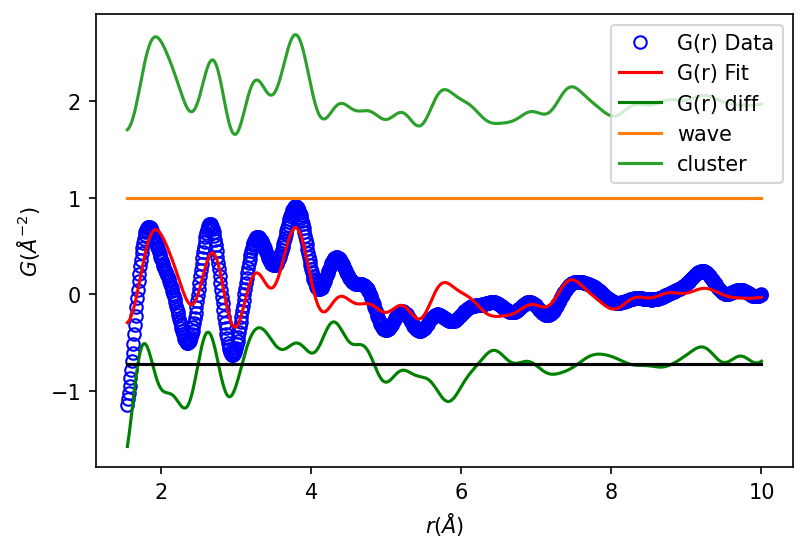

In [20]:
fig, ax = subplots(dpi=150)
plotRecipe(recipe, ax);
ax.plot(r, gwave+1, label='wave')
ax.plot(r, g1+2, label='cluster')
ax.legend();

In [21]:
r = recipe.pdf.profile.x
g = recipe.pdf.profile.y
gcalc = recipe.pdf.evaluate()
pdf = np.column_stack([r,g, gcalc])
np.savetxt(grdata + "_" + xyzfile1  + '_fit'  + '.cgr', pdf)    
with open(grdata + "_" + xyzfile1 + '_fit' + '_parameters.txt', 'w') as outfile:
    print(FitResults(recipe), file = outfile)
outfile.close()

## Export refined structures

In [22]:
from ase.io import read, write
import re

with open('refined_cluster.xyz', 'w') as outfile:
    print(len(atoms1), file = outfile)
    print(' ', file=outfile)
    for i in range(len(atoms1)):
        print(atoms1[i], file = outfile)
outfile.close()

file_name = 'refined_cluster.xyz' 
structure = read(file_name)

xyz_positions = structure.get_positions().copy()

FitResults(recipe).saveResults('fitresults.txt')
zoomscales = []
with open('fitresults.txt') as f:
    for line in f:
        if len(re.findall('zoom',line)) != 0:
            zoomscales.append(float(line.split()[-1]))
f.close()

print(zoomscales)

xyz_positions[:,0] *= zoomscales[0]
xyz_positions[:,1] *= zoomscales[1]
xyz_positions[:,2] *= zoomscales[2]

structure.set_positions(xyz_positions)

write(file_name, structure)

[1.03003354, 0.969981023, 1.03005248]
